# CPI-Bond Yield Model

This notebook implements a simple ML/linear model to predict bond yield changes from CPI shocks and background macroeconomic variables.

**Key Features:**
- Event-based modeling using CPI announcement dates (not daily forward-filled values)
- Walk-forward backtest with month-sized blocks (30% test set)
- Anti-overfitting measures: regularization, block-based validation, large test set


In [19]:
import sys
from pathlib import Path
import importlib

# Add src to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.models.prepare_data import prepare_event_data, create_train_test_split
from src.models.cpi_yield_model import CPIBondYieldModel, TwoStageCPIBondYieldModel, RegimeSwitchingCPIBondYieldModel
from src.models.backtest import WalkForwardBacktest
from src.utils.logging_utils import setup_logging

# Reload modules to pick up latest changes
import src.models.cpi_yield_model
import src.models.backtest
importlib.reload(src.models.cpi_yield_model)
importlib.reload(src.models.backtest)
from src.models.cpi_yield_model import CPIBondYieldModel, TwoStageCPIBondYieldModel, RegimeSwitchingCPIBondYieldModel
from src.models.backtest import WalkForwardBacktest

# Set up logging
setup_logging()

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


In [20]:
# Model configuration
TARGET_YIELD = "y_2y"  # Focus on shorter-term yield (more sensitive to CPI shocks)
PREDICTION_HORIZON = 0  # Days after announcement (0 = same day, 1 = next day, etc.)
TEST_SIZE = 0.3  # Proportion of data for testing

# Model type: "single_stage", "two_stage", or "regime_switching"
# Single stage: Direct regression of yield_change from all features
# Two stage: Stage 1 learns regime (baseline yield), Stage 2 learns CPI shock effect (linear)
# Regime switching: Stage 1 classifies regime, Stage 2 has regime-specific non-linear models
MODEL_ARCHITECTURE = "regime_switching"  # Options: "single_stage", "two_stage", or "regime_switching"

# For single-stage model
MODEL_TYPE = "ridge"
ALPHA = 1.0
USE_HYPERPARAMETER_TUNING = True

# For two-stage model (linear)
REGIME_MODEL_TYPE = "ridge"
SHOCK_MODEL_TYPE = "ridge"
REGIME_ALPHA = 1.0
SHOCK_ALPHA = 1.0

# For regime-switching model (non-linear)
N_REGIMES = 3  # Number of regimes to classify
REGIME_CLASSIFIER_TYPE = "random_forest"  # Classifier for regime
SHOCK_MODEL_TYPE_NL = "random_forest"  # Non-linear model for each regime ("random_forest" or "gradient_boosting")
USE_CLASSIFICATION = True  # If True, classify into bins (noise/small/medium/large/very large)

# Bin thresholds in basis points (yield changes are in percentage points, so 10bp = 0.10)
# Creates bins: very_large_down (<-30bp), large_down (-30 to -10bp), medium_down (-10 to -3bp),
#               noise (-3 to +3bp), medium_up (+3 to +10bp), large_up (+10 to +30bp), very_large_up (>+30bp)
BIN_THRESHOLDS_BP = [-30, -10, -3, 3, 10, 30]  # In basis points

# Backtest configuration
BLOCK_SIZE_DAYS = 90  # Size of validation blocks (~3 months)
MIN_TRAIN_SIZE = 50  # Minimum events in training set

print(f"Target: {TARGET_YIELD} (shorter-term yield)")
print(f"Prediction horizon: {PREDICTION_HORIZON} days (same-day reaction)")
print(f"Model Architecture: {MODEL_ARCHITECTURE}")
if MODEL_ARCHITECTURE == "regime_switching":
    print(f"  Number of Regimes: {N_REGIMES}")
    print(f"  Regime Classifier: {REGIME_CLASSIFIER_TYPE}")
    print(f"  Shock Models: {SHOCK_MODEL_TYPE_NL} (non-linear, one per regime)")
    print(f"  Classification Mode: {USE_CLASSIFICATION}")
    if USE_CLASSIFICATION:
        print(f"  Bin Thresholds: {BIN_THRESHOLDS_BP} bp")
        print(f"    Bins: very_large_down, large_down, medium_down, noise, medium_up, large_up, very_large_up")
elif MODEL_ARCHITECTURE == "two_stage":
    print(f"  Regime Model: {REGIME_MODEL_TYPE} (alpha={REGIME_ALPHA})")
    print(f"  Shock Model: {SHOCK_MODEL_TYPE} (alpha={SHOCK_ALPHA})")
else:
    print(f"  Model: {MODEL_TYPE} (alpha={ALPHA})")
    print(f"  Hyperparameter tuning: {USE_HYPERPARAMETER_TUNING}")
print(f"Test size: {TEST_SIZE*100:.0f}%")


Target: y_2y (shorter-term yield)
Prediction horizon: 0 days (same-day reaction)
Model Architecture: regime_switching
  Number of Regimes: 3
  Regime Classifier: random_forest
  Shock Models: random_forest (non-linear, one per regime)
  Classification Mode: True
  Bin Thresholds: [-30, -10, -3, 3, 10, 30] bp
    Bins: very_large_down, large_down, medium_down, noise, medium_up, large_up, very_large_up
Test size: 30%


## Load and Prepare Data

Load the event-based dataset using CPI announcement dates.


In [21]:
# Prepare event-based dataset
print("Preparing event-based dataset...")
events_df = prepare_event_data(
    target_yield=TARGET_YIELD,
    prediction_horizon=PREDICTION_HORIZON,
    start_date=None,  # Use all available data
    end_date=None
)

print(f"\nDataset shape: {events_df.shape}")
print(f"Date range: {events_df['date'].min()} to {events_df['date'].max()}")
print(f"\nColumns: {list(events_df.columns)}")
print(f"\nFirst few rows:")
events_df.head(10)


Preparing event-based dataset...
2025-12-03 23:38:27 - src.models.prepare_data - INFO - Preparing event-based CPI-Bond Yield dataset...
2025-12-03 23:38:27 - src.models.prepare_data - INFO - Loading Fed panel...
2025-12-03 23:38:27 - src.data.merge_panel - INFO - Building Fed panel...
2025-12-03 23:38:27 - src.data.merge_panel - INFO - Loading FRED data...
2025-12-03 23:38:27 - src.data.fred_loader - INFO - Merging 13 FRED series into daily panel...
2025-12-03 23:38:27 - src.data.fred_loader - INFO - Computed slope_10y_2y = y_10y - y_2y
2025-12-03 23:38:27 - src.data.fred_loader - INFO - Computed CPI YoY change
2025-12-03 23:38:27 - src.data.fred_loader - INFO - Saved processed FRED panel to /home/bitzaven/CodingProjects/ExamplesFixedIncomeModelling/data/processed/fred_daily_panel.parquet
2025-12-03 23:38:27 - src.data.fred_loader - INFO - Merged panel shape: (28826, 16)
2025-12-03 23:38:27 - src.data.merge_panel - INFO - Loading FedWatch probability data...
2025-12-03 23:38:27 - src.d

,date,data_period,cpi_shock_mom,cpi_shock_yoy,cpi_shock_magnitude,cpi_level,y_2y_before,y_2y_change,y_2y_lagged,yield_lagged,yield_volatility,gdp,unemployment,fed_funds,slope_10y_2y,cpi_shock_x_fed_funds,cpi_shock_x_unemployment,cpi_shock_x_volatility,vix,hy_oas,stlfsi
0,1994-02-17,1947-01,NaN,2.515723,NaN,21.48,4.44,0.06,4.44,4.44,0.038919,10939.116,6.6,3.25,1.5,NaN,NaN,NaN,13.79,NaN,-0.3101
1,1994-02-17,1947-02,0.651769,2.515723,0.651769,21.62,4.44,0.06,4.44,4.44,0.038919,10939.116,6.6,3.25,1.5,2.118250,4.301676,0.025366,13.79,NaN,-0.3101
2,1994-02-17,1947-03,1.757632,2.515723,1.757632,22.00,4.44,0.06,4.44,4.44,0.038919,10939.116,6.6,3.25,1.5,5.712303,11.600370,0.068405,13.79,NaN,-0.3101
3,1994-02-17,1947-04,0.000000,2.515723,0.000000,22.00,4.44,0.06,4.44,4.44,0.038919,10939.116,6.6,3.25,1.5,0.000000,0.000000,0.000000,13.79,NaN,-0.3101
4,1994-02-17,1947-05,-0.227273,2.515723,0.227273,21.95,4.44,0.06,4.44,4.44,0.038919,10939.116,6.6,3.25,1.5,-0.738636,-1.500000,-0.008845,13.79,NaN,-0.3101
5,1994-02-17,1947-06,0.592255,2.515723,0.592255,22.08,4.44,0.06,4.44,4.44,0.038919,10939.116,6.6,3.25,1.5,1.924829,3.908884,0.023050,13.79,NaN,-0.3101
6,1994-02-17,1947-07,0.679348,2.515723,0.679348,22.23,4.44,0.06,4.44,4.44,0.038919,10939.116,6.6,3.25,1.5,2.207880,4.483696,0.026439,13.79,NaN,-0.3101
7,1994-02-17,1947-08,0.764732,2.515723,0.764732,22.40,4.44,0.06,4.44,4.44,0.038919,10939.116,6.6,3.25,1.5,2.485380,5.047233,0.029763,13.79,NaN,-0.3101
8,1994-02-17,1947-09,1.964286,2.515723,1.964286,22.84,4.44,0.06,4.44,4.44,0.038919,10939.116,6.6,3.25,1.5,6.383929,12.964286,0.076448,13.79,NaN,-0.3101
9,1994-02-17,1947-10,0.306480,2.515723,0.306480,22.91,4.44,0.06,4.44,4.44,0.038919,10939.116,6.6,3.25,1.5,0.996060,2.022767,0.011928,13.79,NaN,-0.3101


## Data Exploration

Explore the prepared dataset.


In [22]:
# Summary statistics
print("Summary Statistics:")
print(events_df.describe())

print(f"\nMissing values:")
print(events_df.isnull().sum())


Summary Statistics:
                                date  cpi_shock_mom  cpi_shock_yoy  \
count                            880     879.000000     880.000000   
mean   1998-11-05 03:57:16.363636480       0.270135       3.272199   
min              1976-06-22 00:00:00      -1.770548      -2.988129   
25%              1994-02-17 00:00:00       0.096665       1.608887   
50%              1994-02-17 00:00:00       0.238729       2.739092   
75%              2007-06-23 06:00:00       0.414022       4.138770   
max              2025-10-24 00:00:00       1.964286      14.592275   
std                              NaN       0.332831       2.699365   

       cpi_shock_magnitude   cpi_level  y_2y_before  y_2y_change  y_2y_lagged  \
count           879.000000  880.000000   880.000000   880.000000   880.000000   
mean              0.323784  129.103930     4.805511     0.015102     4.805511   
min               0.000000   21.480000     0.110000    -0.540000     0.110000   
25%               0.13277

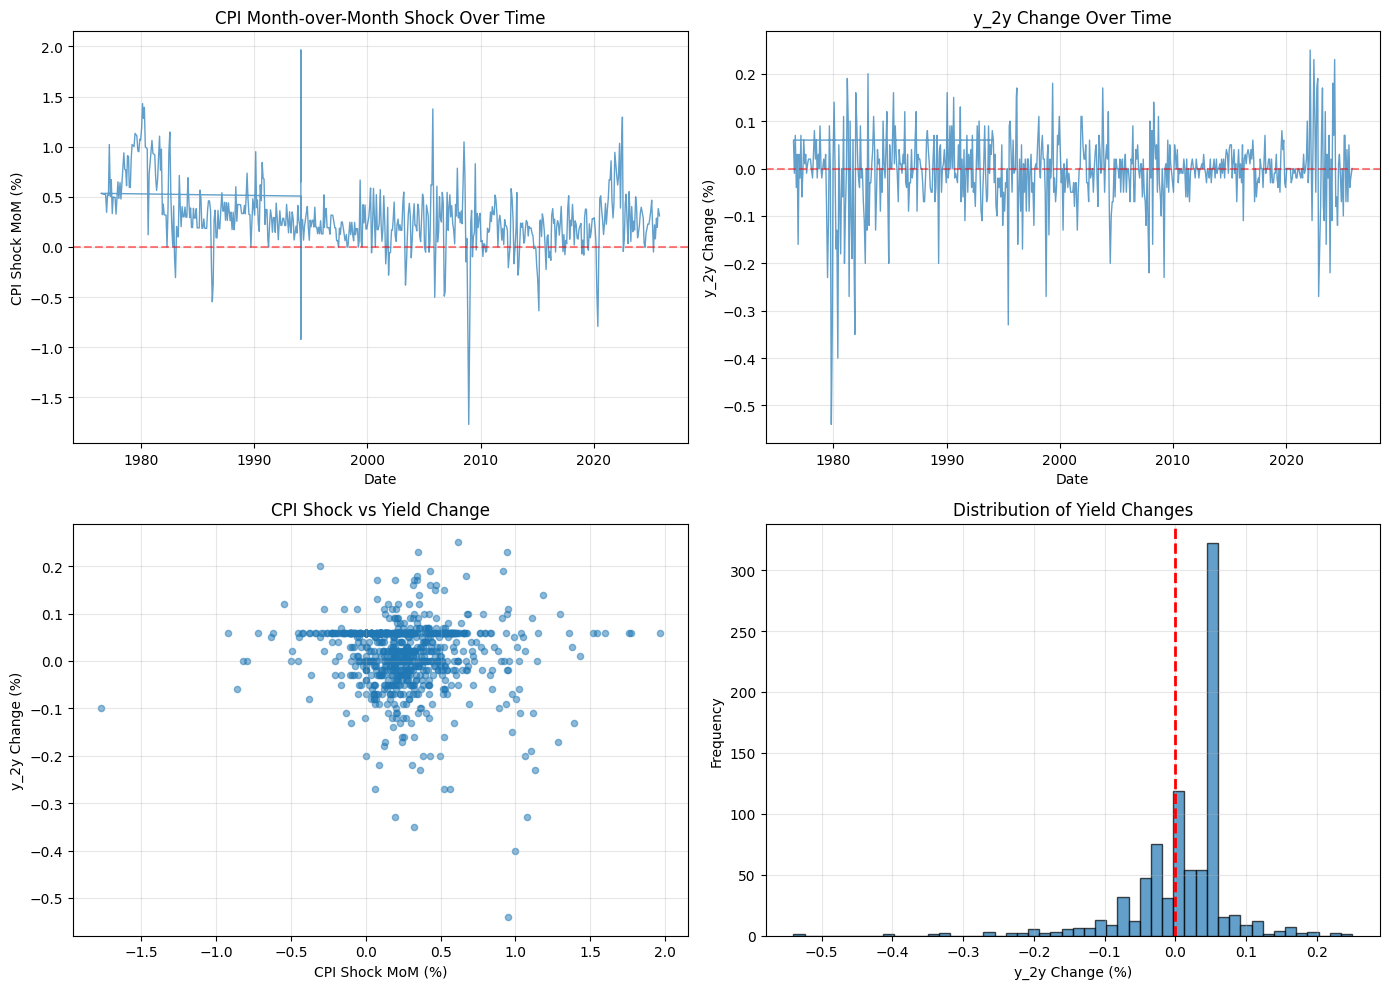

In [23]:
# Visualize key variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# CPI Shock MoM over time
ax1 = axes[0, 0]
ax1.plot(events_df['date'], events_df['cpi_shock_mom'], alpha=0.7, linewidth=1)
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('CPI Shock MoM (%)')
ax1.set_title('CPI Month-over-Month Shock Over Time')
ax1.grid(True, alpha=0.3)

# Yield change over time
ax2 = axes[0, 1]
target_col = f'{TARGET_YIELD}_change'
ax2.plot(events_df['date'], events_df[target_col], alpha=0.7, linewidth=1)
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('Date')
ax2.set_ylabel(f'{TARGET_YIELD} Change (%)')
ax2.set_title(f'{TARGET_YIELD} Change Over Time')
ax2.grid(True, alpha=0.3)

# Scatter: CPI shock vs Yield change
ax3 = axes[1, 0]
valid_mask = ~(events_df['cpi_shock_mom'].isna() | events_df[target_col].isna())
ax3.scatter(events_df.loc[valid_mask, 'cpi_shock_mom'], 
            events_df.loc[valid_mask, target_col], alpha=0.5, s=20)
ax3.set_xlabel('CPI Shock MoM (%)')
ax3.set_ylabel(f'{TARGET_YIELD} Change (%)')
ax3.set_title('CPI Shock vs Yield Change')
ax3.grid(True, alpha=0.3)

# Distribution of yield changes
ax4 = axes[1, 1]
ax4.hist(events_df[target_col].dropna(), bins=50, alpha=0.7, edgecolor='black')
ax4.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax4.set_xlabel(f'{TARGET_YIELD} Change (%)')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Yield Changes')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Train/Test Split

Create chronological train/test split (30% test set).


In [24]:
# Create train/test split
train_df, test_df = create_train_test_split(
    events_df,
    test_size=TEST_SIZE,
    min_train_size=MIN_TRAIN_SIZE
)

print(f"Training set: {len(train_df)} events")
print(f"Test set: {len(test_df)} events")
print(f"\nTraining date range: {train_df['date'].min()} to {train_df['date'].max()}")
print(f"Test date range: {test_df['date'].min()} to {test_df['date'].max()}")


2025-12-03 23:38:31 - src.models.prepare_data - INFO - Train/test split: 616 train, 264 test
2025-12-03 23:38:31 - src.models.prepare_data - INFO - Train date range: 1976-06-22 00:00:00 to 2003-10-16 00:00:00
2025-12-03 23:38:31 - src.models.prepare_data - INFO - Test date range: 2003-11-18 00:00:00 to 2025-10-24 00:00:00
Training set: 616 events
Test set: 264 events

Training date range: 1976-06-22 00:00:00 to 2003-10-16 00:00:00
Test date range: 2003-11-18 00:00:00 to 2025-10-24 00:00:00


## Model Training

Train the model on the training set.


In [25]:
# Initialize model based on architecture
if MODEL_ARCHITECTURE == "regime_switching":
    print("Initializing Regime-Switching Non-Linear Model...")
    print("Stage 1: Regime Classifier (classifies regime from background factors)")
    print("Stage 2: Regime-Specific Shock Models (non-linear models, one per regime)")
    
    model = RegimeSwitchingCPIBondYieldModel(
        n_regimes=N_REGIMES,
        regime_classifier_type=REGIME_CLASSIFIER_TYPE,
        shock_model_type=SHOCK_MODEL_TYPE_NL,
        scale_features=True,
        use_classification=USE_CLASSIFICATION,
        bin_thresholds_bp=BIN_THRESHOLDS_BP if USE_CLASSIFICATION else None
    )
    
elif MODEL_ARCHITECTURE == "two_stage":
    print("Initializing Two-Stage Shock-Based Model...")
    print("Stage 1: Regime Model (predicts baseline yield from background factors)")
    print("Stage 2: Shock Model (predicts yield change from CPI shock, conditioned on regime)")
    
    model = TwoStageCPIBondYieldModel(
        regime_model_type=REGIME_MODEL_TYPE,
        shock_model_type=SHOCK_MODEL_TYPE,
        regime_alpha=REGIME_ALPHA,
        shock_alpha=SHOCK_ALPHA,
        scale_features=True
    )
    
    # Fit both stages
    print("\n" + "="*60)
    if MODEL_ARCHITECTURE == "regime_switching":
        print("FITTING REGIME-SWITCHING MODEL")
    else:
        print("FITTING TWO-STAGE MODEL")
    print("="*60)
    train_metrics = model.fit(
        train_df,
        target_yield=TARGET_YIELD
    )
    
    print("\n" + "="*60)
    print("TRAINING METRICS SUMMARY")
    print("="*60)
    
    if MODEL_ARCHITECTURE == "regime_switching":
        print("\nStage 1 (Regime Classifier):")
        print(f"  Accuracy: {train_metrics.get('regime_train_accuracy', 'N/A'):.4f}")
        print(f"  Regime Distribution: {train_metrics.get('regime_distribution', {})}")
        
        print("\nStage 2 (Regime-Specific Shock Models):")
        for regime in range(N_REGIMES):
            if f'regime_{regime}_rmse' in train_metrics:
                print(f"\n  Regime {regime}:")
                print(f"    RMSE: {train_metrics.get(f'regime_{regime}_rmse', 'N/A'):.4f}")
                print(f"    MAE:  {train_metrics.get(f'regime_{regime}_mae', 'N/A'):.4f}")
                print(f"    R²:   {train_metrics.get(f'regime_{regime}_r2', 'N/A'):.4f}")
                print(f"    n:    {train_metrics.get(f'regime_{regime}_n_samples', 'N/A')}")
    else:
        print("\nStage 1 (Regime Model) - Baseline Yield Prediction:")
        print(f"  RMSE: {train_metrics.get('regime_train_rmse', 'N/A'):.4f}")
        print(f"  MAE:  {train_metrics.get('regime_train_mae', 'N/A'):.4f}")
        print(f"  R²:   {train_metrics.get('regime_train_r2', 'N/A'):.4f}")
        if 'regime_cv_rmse' in train_metrics:
            print(f"  CV RMSE: {train_metrics['regime_cv_rmse']:.4f} ± {train_metrics.get('regime_cv_rmse_std', 0):.4f}")
        
        print("\nStage 2 (Shock Model) - CPI Shock Propagation:")
        print(f"  RMSE: {train_metrics.get('shock_train_rmse', 'N/A'):.4f}")
        print(f"  MAE:  {train_metrics.get('shock_train_mae', 'N/A'):.4f}")
        print(f"  R²:   {train_metrics.get('shock_train_r2', 'N/A'):.4f}")
        if 'shock_cv_rmse' in train_metrics:
            print(f"  CV RMSE: {train_metrics['shock_cv_rmse']:.4f} ± {train_metrics.get('shock_cv_rmse_std', 0):.4f}")
    
else:
    # Single-stage model
    model = CPIBondYieldModel(
        model_type=MODEL_TYPE,
        alpha=ALPHA,
        scale_features=True
    )
    
    # Hyperparameter tuning if enabled
    if USE_HYPERPARAMETER_TUNING and MODEL_TYPE in ["ridge", "lasso", "elasticnet"]:
        print("Tuning hyperparameters...")
        tune_results = model.tune_hyperparameters(
            train_df,
            target_yield=TARGET_YIELD,
            cv_folds=5
        )
        print(f"\nBest parameters: {tune_results['best_params']}")
        print(f"Best CV RMSE: {tune_results['best_cv_rmse']:.4f}")
    else:
        # Fit model without tuning
        train_metrics = model.fit(
            train_df,
            target_yield=TARGET_YIELD,
            cv=5  # 5-fold cross-validation
        )
        print("\nTraining Metrics:")
        for key, value in train_metrics.items():
            print(f"  {key}: {value:.4f}" if isinstance(value, (int, float)) else f"  {key}: {value}")


Initializing Regime-Switching Non-Linear Model...
Stage 1: Regime Classifier (classifies regime from background factors)
Stage 2: Regime-Specific Shock Models (non-linear models, one per regime)
2025-12-03 23:38:31 - src.models.cpi_yield_model - INFO - Initialized regime-switching model: 3 regimes, classifier=random_forest, shock=random_forest


In [26]:
# Feature importance and analysis
if MODEL_ARCHITECTURE == "regime_switching":
    print("="*60)
    print("MODEL ANALYSIS")
    print("="*60)
    
    # Check if model is fitted
    if not hasattr(model, 'regime_fitted') or not model.regime_fitted:
        print("ERROR: Model must be fitted first. Please run the model training cell (Cell 12) before this analysis.")
    else:
        # Get regime predictions
        train_regimes = model.predict_regime(train_df)
        regime_dist = pd.Series(train_regimes).value_counts().sort_index()
        
        print(f"\nRegime Distribution on Training Set:")
        for regime, count in regime_dist.items():
            pct = count / len(train_regimes) * 100
            print(f"  Regime {regime}: {count} events ({pct:.1f}%)")
        
        # Plot regime distribution over time
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        ax1 = axes[0]
        ax1.scatter(train_df['date'], train_regimes, alpha=0.6, s=30, c=train_regimes, cmap='viridis')
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('Regime', fontsize=12)
        ax1.set_title('Regime Classification Over Time', fontsize=14, fontweight='bold')
        ax1.set_yticks(range(N_REGIMES))
        ax1.grid(True, alpha=0.3)
        
        ax2 = axes[1]
        ax2.bar(regime_dist.index, regime_dist.values, alpha=0.7, color='steelblue')
        ax2.set_xlabel('Regime', fontsize=12)
        ax2.set_ylabel('Number of Events', fontsize=12)
        ax2.set_title('Regime Distribution', fontsize=14, fontweight='bold')
        ax2.set_xticks(range(N_REGIMES))
        ax2.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
        
        print("\nNote: Each regime has its own non-linear model for CPI shock effects")
    
elif MODEL_ARCHITECTURE == "two_stage":
    print("="*60)
    print("MODEL ANALYSIS")
    print("="*60)
    
    # Regime model analysis
    print("\nStage 1 (Regime Model) - Predicting Baseline Yield:")
    print("This model learns what yield should be given background factors (regime encoding)")
    
    # Get regime predictions on training set
    baseline_pred = model.predict_regime(train_df, target_yield=TARGET_YIELD)
    baseline_actual = train_df[f'{TARGET_YIELD}_before'].values
    
    # Plot regime predictions
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1 = axes[0]
    ax1.scatter(baseline_actual, baseline_pred, alpha=0.5, s=20)
    min_val = min(baseline_actual.min(), baseline_pred.min())
    max_val = max(baseline_actual.max(), baseline_pred.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    ax1.set_xlabel('Actual Baseline Yield (%)', fontsize=12)
    ax1.set_ylabel('Predicted Baseline Yield (%)', fontsize=12)
    ax1.set_title('Regime Model: Baseline Yield Prediction', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2 = axes[1]
    ax2.plot(train_df['date'], baseline_actual, label='Actual', alpha=0.7, linewidth=1.5)
    ax2.plot(train_df['date'], baseline_pred, label='Predicted', alpha=0.7, linewidth=1.5)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Baseline Yield (%)', fontsize=12)
    ax2.set_title('Regime Model: Baseline Yield Over Time', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nStage 2 (Shock Model) - CPI Shock Propagation:")
    print("This model learns how CPI shocks affect yield, conditioned on the regime")
    print("(Feature importance not easily extractable for two-stage model)")
    
else:
    # Single-stage model
    feature_importance = model.get_feature_importance()
    print("Feature Importance (Coefficients):")
    print(feature_importance.to_string(index=False))
    
    # Plot learning curve
    print("\nPlotting learning curve...")
    model.plot_learning_curve(train_df, target_yield=TARGET_YIELD)


MODEL ANALYSIS
ERROR: Model must be fitted first. Please run the model training cell (Cell 12) before this analysis.


## Walk-Forward Backtest

Run walk-forward backtest with month-sized blocks on the test set.


In [27]:
# Initialize backtest
backtest = WalkForwardBacktest(
    block_size_days=BLOCK_SIZE_DAYS,
    min_train_size=MIN_TRAIN_SIZE,
    retrain_frequency="block"
)

# Run backtest
backtest_results = backtest.run(
    train_df=train_df,
    test_df=test_df,
    model=model,
    target_yield=TARGET_YIELD
)


2025-12-03 23:38:31 - src.models.backtest - INFO - Initialized walk-forward backtest: block_size=90 days, min_train=50
2025-12-03 23:38:31 - src.models.backtest - INFO - Starting walk-forward backtest...
2025-12-03 23:38:31 - src.models.backtest - INFO - Train size: 616, Test size: 264
2025-12-03 23:38:31 - src.models.backtest - INFO - Split test set into 90 blocks
2025-12-03 23:38:31 - src.models.backtest - INFO - Initial training on training set...
2025-12-03 23:38:31 - src.models.cpi_yield_model - INFO - Fitting Stage 1: Regime classifier...
2025-12-03 23:38:31 - src.models.cpi_yield_model - INFO - Regime classifier - Accuracy: 1.0000
2025-12-03 23:38:31 - src.models.cpi_yield_model - INFO - Regime distribution: {0: 22, 1: 388, 2: 206}
2025-12-03 23:38:31 - src.models.cpi_yield_model - INFO - Fitting Stage 2: Regime-specific shock models...
2025-12-03 23:38:31 - src.models.cpi_yield_model - INFO - Regime 0 shock model - Accuracy: 1.0000, n=22
2025-12-03 23:38:31 - src.models.cpi_yie

/home/bitzaven/CodingProjects/ExamplesFixedIncomeModelling/src/models/backtest.py:113: RuntimeWarning: divide by zero encountered in scalar divide
  block_r2 = 1 - np.sum((actuals[valid_mask_block] - predictions_continuous[valid_mask_block]) ** 2) / np.sum((actuals[valid_mask_block] - np.mean(actuals[valid_mask_block])) ** 2)


2025-12-03 23:39:22 - src.models.cpi_yield_model - INFO - Regime 0 shock model - Accuracy: 0.8939, n=179
2025-12-03 23:39:22 - src.models.cpi_yield_model - INFO -   Bin distribution: {1: 5, 2: 32, 3: 108, 4: 32, 5: 2}
2025-12-03 23:39:23 - src.models.cpi_yield_model - INFO - Regime 1 shock model - Accuracy: 0.9698, n=364
2025-12-03 23:39:23 - src.models.cpi_yield_model - INFO -   Bin distribution: {1: 3, 2: 22, 3: 33, 4: 304, 5: 2}
2025-12-03 23:39:23 - src.models.cpi_yield_model - INFO - Regime 2 shock model - Accuracy: 0.6838, n=272
2025-12-03 23:39:23 - src.models.cpi_yield_model - INFO -   Bin distribution: {0: 5, 1: 28, 2: 62, 3: 99, 4: 57, 5: 21}
2025-12-03 23:39:23 - src.models.backtest - INFO - Processing block 68/90 (3 events)...
2025-12-03 23:39:23 - src.models.backtest - INFO - Retraining model on expanded training set (818 events)...
2025-12-03 23:39:23 - src.models.cpi_yield_model - INFO - Fitting Stage 1: Regime classifier...
2025-12-03 23:39:23 - src.models.cpi_yield_mod

/home/bitzaven/CodingProjects/ExamplesFixedIncomeModelling/src/models/backtest.py:113: RuntimeWarning: divide by zero encountered in scalar divide
  block_r2 = 1 - np.sum((actuals[valid_mask_block] - predictions_continuous[valid_mask_block]) ** 2) / np.sum((actuals[valid_mask_block] - np.mean(actuals[valid_mask_block])) ** 2)


2025-12-03 23:39:40 - src.models.cpi_yield_model - INFO - Regime 0 shock model - Accuracy: 0.8341, n=205
2025-12-03 23:39:40 - src.models.cpi_yield_model - INFO -   Bin distribution: {1: 6, 2: 32, 3: 126, 4: 35, 5: 6}
2025-12-03 23:39:40 - src.models.cpi_yield_model - INFO - Regime 1 shock model - Accuracy: 0.9501, n=381
2025-12-03 23:39:40 - src.models.cpi_yield_model - INFO -   Bin distribution: {1: 4, 2: 25, 3: 40, 4: 309, 5: 3}
2025-12-03 23:39:40 - src.models.cpi_yield_model - INFO - Regime 2 shock model - Accuracy: 0.6837, n=294
2025-12-03 23:39:40 - src.models.cpi_yield_model - INFO -   Bin distribution: {0: 5, 1: 35, 2: 68, 3: 99, 4: 61, 5: 26}
2025-12-03 23:39:40 - src.models.backtest - WARNING - Could not evaluate regime model: RegimeSwitchingCPIBondYieldModel.predict_regime() got an unexpected keyword argument 'target_yield'
2025-12-03 23:39:40 - src.models.backtest - INFO - Backtest complete: RMSE=0.0957, MAE=0.0607, R²=-1.1045, Dir Acc=0.3030
2025-12-03 23:39:40 - src.mode

In [28]:
# Print summary
backtest.print_summary(backtest_results)



BACKTEST SUMMARY
Number of blocks: 90
Total predictions: 264

Stage 2 (Shock Model) - Overall Metrics:
  RMSE: 0.0957
  MAE:  0.0607
  R²:   -1.1045
  Directional Accuracy: 0.3030

Binned Evaluation:
  Overall Bin Accuracy: 0.6553
  Small Move Accuracy: 0.7074 (n=188)
  Medium Move Accuracy: 0.5902 (n=61)
  Large Move Accuracy: 0.2667 (n=15)

Final Test Score: 0.5946

Block-wise Performance:
 block_idx start_date   end_date  n_events     rmse            r2  directional_accuracy
         0 2003-11-18 2004-01-15         3 0.035590  1.110223e-16              0.000000
         1 2004-02-20 2004-05-14         4 0.076974 -1.463120e-01              0.000000
         2 2004-06-15 2004-07-16         2 0.220737 -1.849000e+01              0.000000
         3 2004-08-17 2004-10-19         3 0.042131  1.388889e-02              0.333333
         4 2004-11-17 2005-01-19         3 0.155161 -1.983413e+01              0.333333
         5 2005-02-23 2005-04-20         3 0.132947 -6.528125e+01           

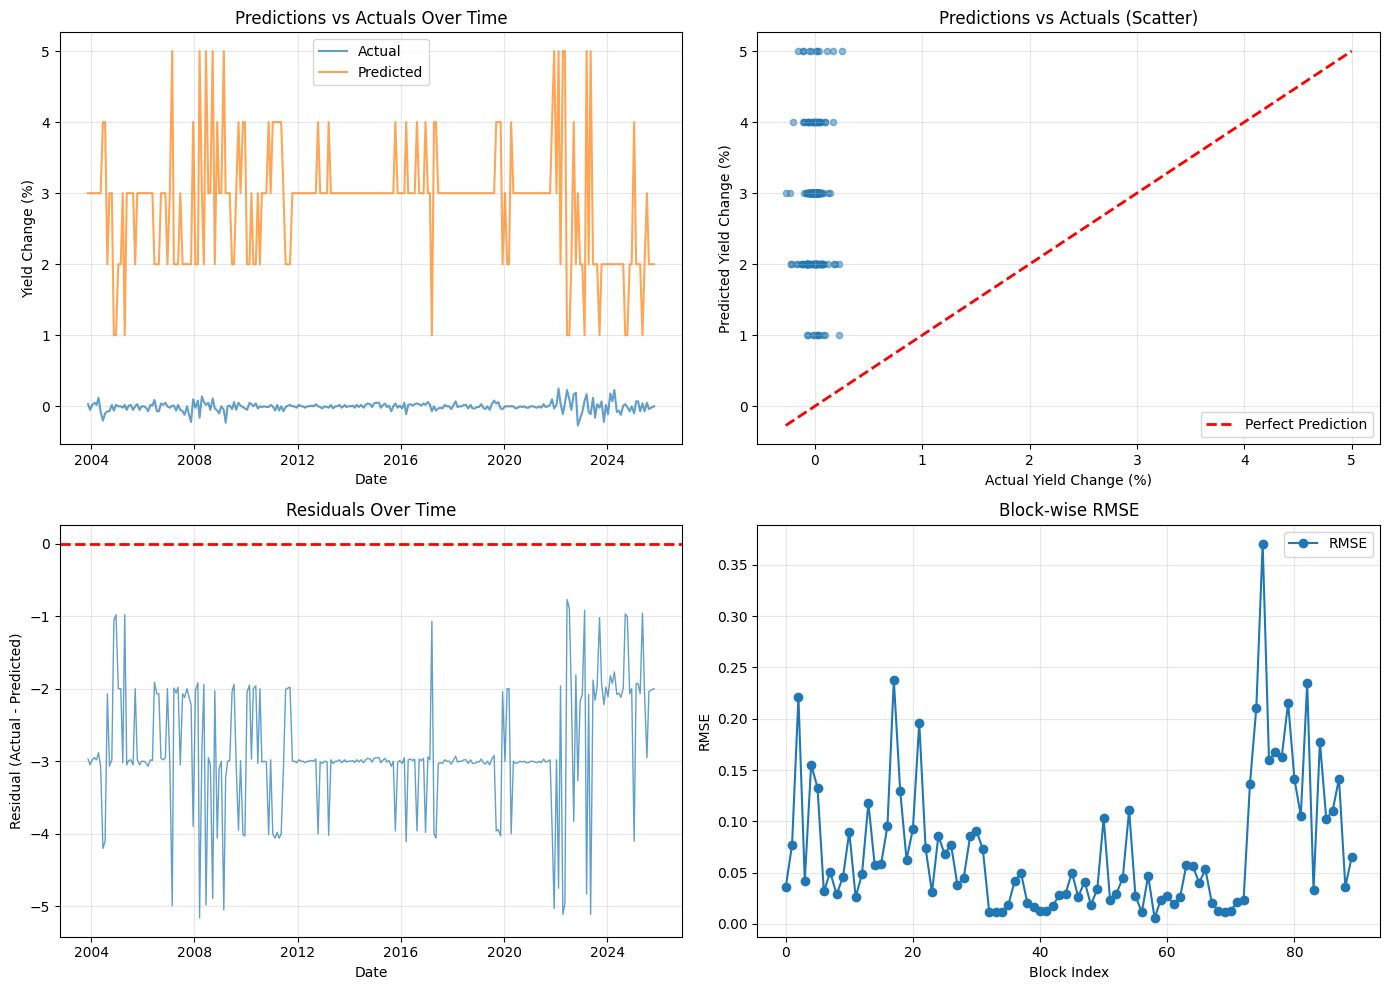


Binned Evaluation:


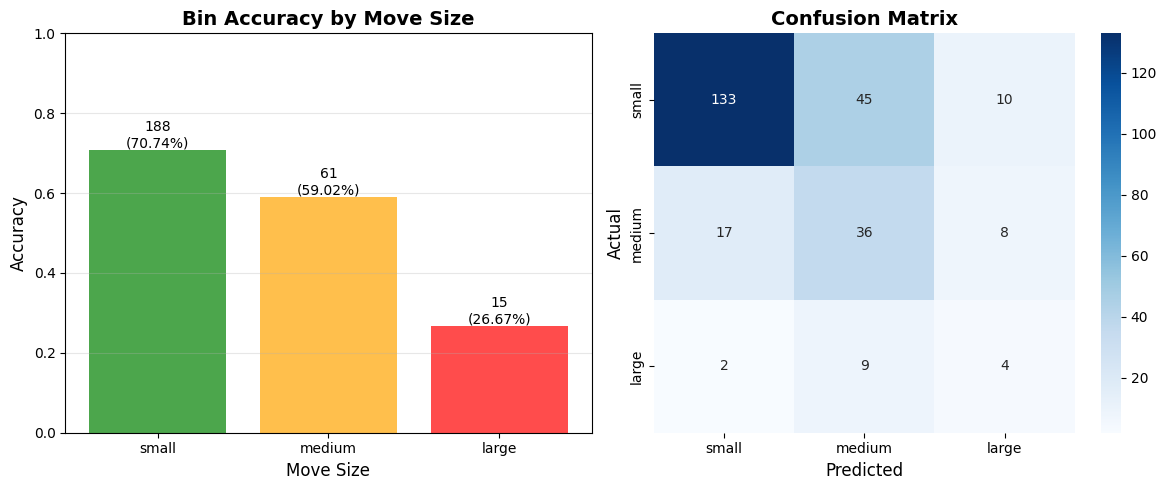

In [29]:
# Plot results
backtest.plot_results(backtest_results, figsize=(14, 10))

# Plot binned evaluation
print("\nBinned Evaluation:")
backtest.plot_binned_evaluation(backtest_results, figsize=(12, 5))


In [ ]:
# IMPORTANT: Re-fit model on ONLY train_df before final evaluation
# The walk-forward backtest above retrained the model on expanding window 
# that included test data. This would cause data leakage if we evaluate now.

print("="*60)
print("RE-FITTING MODEL ON TRAIN DATA ONLY")
print("="*60)
print("\nThe walk-forward backtest retrained the model on train+test data.")
print("Re-fitting on train_df only for clean final evaluation...\n")

model.fit(train_df, target_yield=TARGET_YIELD)
print("\nModel re-fitted on training data only. Ready for clean evaluation.")


## Model Comparison

Compare different model types (optional).


TEST SET EVALUATION (Regime-Switching Model)

Regime Distribution on Test Set:
  Regime 0: 184 events (69.7%)
  Regime 1: 33 events (12.5%)
  Regime 2: 47 events (17.8%)

BIN-WISE CLASSIFICATION PERFORMANCE

Overall Accuracy: 0.7917

Bin-Wise Accuracy:
  large_down          : 0.7647 (n=17)
  medium_down         : 0.8980 (n=49)
  noise               : 0.7887 (n=142)
  medium_up           : 0.6429 (n=42)
  large_up            : 0.9286 (n=14)

LARGE MOVE DETECTION METRICS

Large/Very Large Moves (>10bp or <-30bp):
  Total Large Moves: 31
  Detection Rate: 90.32% (28/31 correctly identified)
  False Negatives: 3 (missed large moves) ⚠️
  False Positives: 4 (predicted large but wasn't) ✓ GOOD - being cautious
  True Positives: 28 (correctly identified large moves) ✓
  Precision: 0.8750 (of predicted large, how many were actually large)
  Recall: 0.9032 (of actual large, how many did we catch)
  F1 Score: 0.8889

FALSE NEGATIVE ANALYSIS - Where do missed large moves go?

False Negatives (3 t

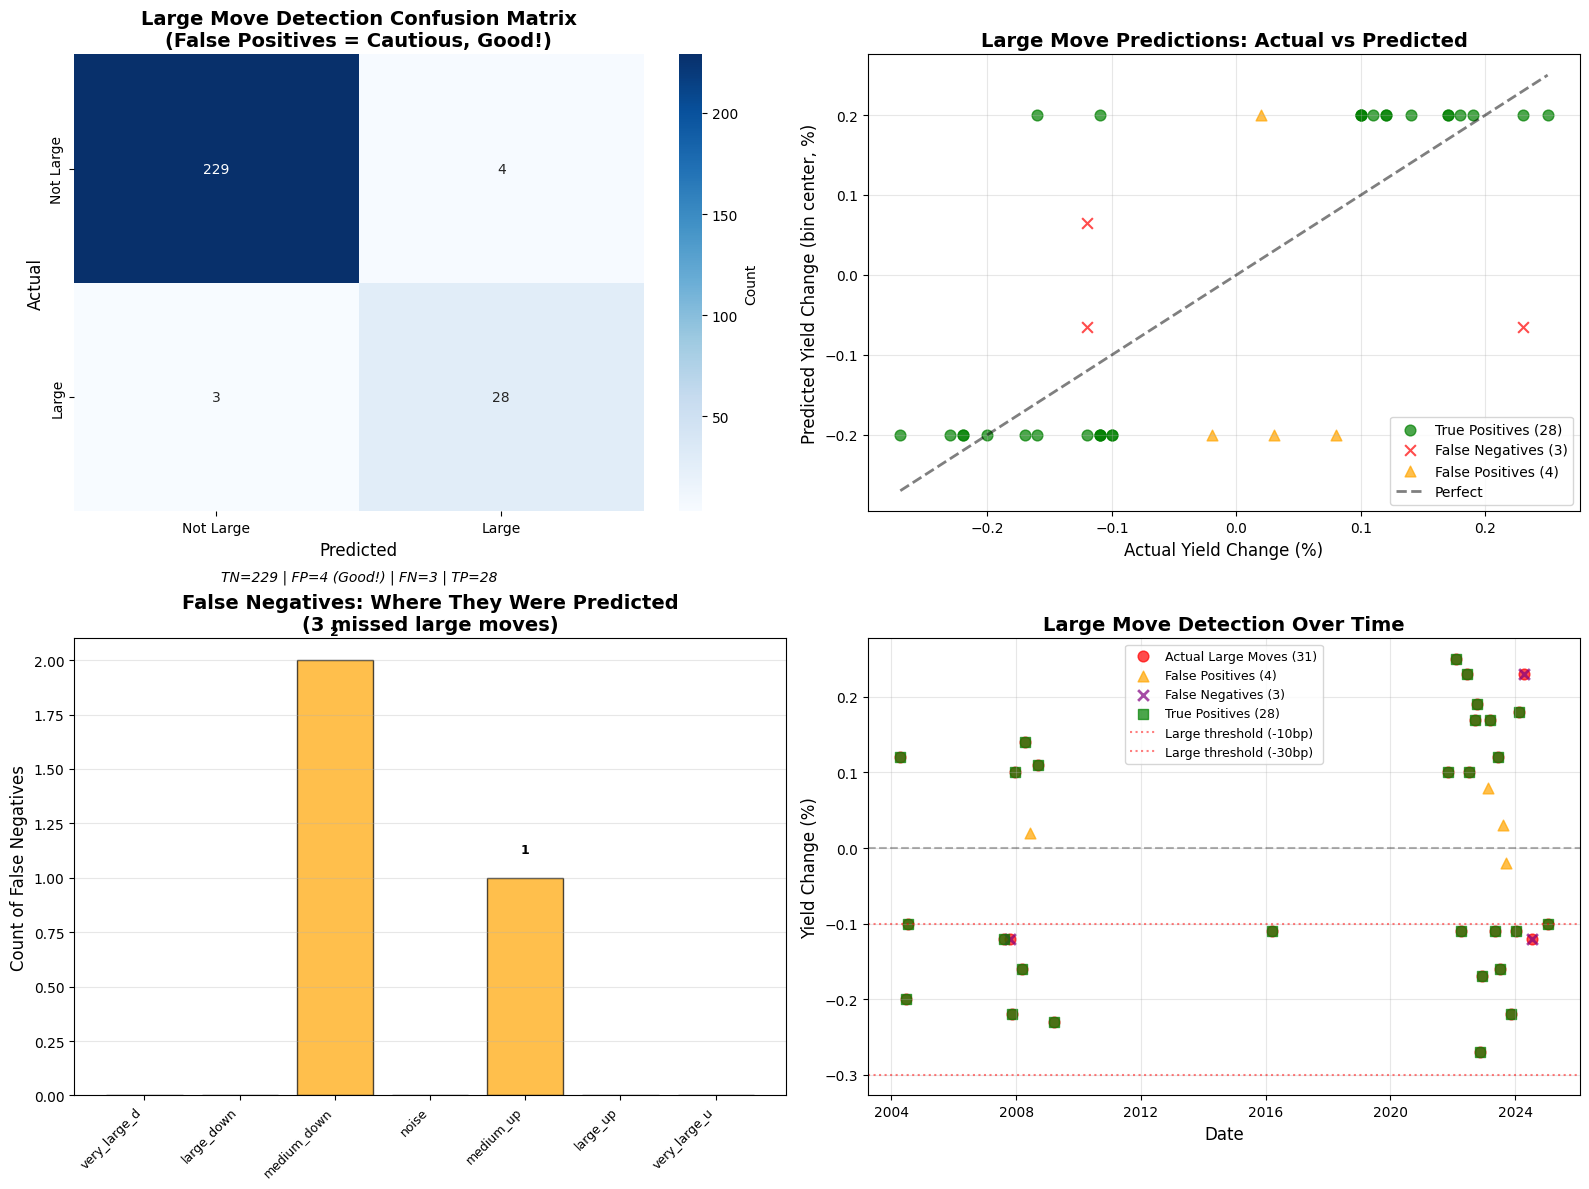


Per-Regime Performance:

  Regime 0:
    Accuracy: 0.8533
    n:        184

  Regime 1:
    Accuracy: 0.7273
    n:        33

  Regime 2:
    Accuracy: 0.5957
    n:        47


In [30]:
# Evaluate on test set
if MODEL_ARCHITECTURE == "regime_switching":
    print("="*60)
    print("TEST SET EVALUATION (Regime-Switching Model)")
    print("="*60)
    
    test_metrics = model.evaluate(test_df, target_yield=TARGET_YIELD)
    
    print(f"\nRegime Distribution on Test Set:")
    regime_dist = test_metrics.get('regime_distribution', {})
    for regime, count in sorted(regime_dist.items()):
        pct = count / test_metrics.get('n_samples', 1) * 100
        print(f"  Regime {regime}: {count} events ({pct:.1f}%)")
    
    if USE_CLASSIFICATION:
        print("\n" + "="*60)
        print("BIN-WISE CLASSIFICATION PERFORMANCE")
        print("="*60)
        
        print(f"\nOverall Accuracy: {test_metrics.get('overall_accuracy', 'N/A'):.4f}")
        
        print("\nBin-Wise Accuracy:")
        bin_accuracy = test_metrics.get('bin_accuracy', {})
        bin_labels = model.bin_labels
        for bin_idx in range(model.n_bins):
            bin_key = f'bin_{bin_idx}_accuracy'
            n_key = f'bin_{bin_idx}_n_samples'
            if bin_key in bin_accuracy:
                label = bin_labels[bin_idx] if bin_idx < len(bin_labels) else f'bin_{bin_idx}'
                acc = bin_accuracy[bin_key]
                n = bin_accuracy.get(n_key, 0)
                print(f"  {label:20s}: {acc:.4f} (n={n})")
        
        print("\n" + "="*60)
        print("LARGE MOVE DETECTION METRICS")
        print("="*60)
        
        large_metrics = test_metrics.get('large_move_detection', {})
        n_large = large_metrics.get('n_large_moves', 0)
        detection_rate = large_metrics.get('detection_rate', 0)
        fn = large_metrics.get('false_negatives', 0)
        fp = large_metrics.get('false_positives', 0)
        tp = large_metrics.get('true_positives', 0)
        precision = large_metrics.get('precision', 0)
        recall = large_metrics.get('recall', 0)
        f1 = large_metrics.get('f1_score', 0)
        
        print(f"\nLarge/Very Large Moves (>{abs(BIN_THRESHOLDS_BP[1])}bp or <{BIN_THRESHOLDS_BP[0]}bp):")
        print(f"  Total Large Moves: {n_large}")
        print(f"  Detection Rate: {detection_rate:.2%} ({tp}/{n_large} correctly identified)")
        print(f"  False Negatives: {fn} (missed large moves) ⚠️")
        print(f"  False Positives: {fp} (predicted large but wasn't) ✓ GOOD - being cautious")
        print(f"  True Positives: {tp} (correctly identified large moves) ✓")
        print(f"  Precision: {precision:.4f} (of predicted large, how many were actually large)")
        print(f"  Recall: {recall:.4f} (of actual large, how many did we catch)")
        print(f"  F1 Score: {f1:.4f}")
        
        # Detailed False Negative Analysis
        print("\n" + "="*60)
        print("FALSE NEGATIVE ANALYSIS - Where do missed large moves go?")
        print("="*60)
        
        # Get false negatives and their predicted bins
        y_true_raw = test_df[f'{TARGET_YIELD}_change'].values
        valid_mask = ~np.isnan(y_true_raw)
        y_true_raw = y_true_raw[valid_mask]
        y_pred_bins = model.predict(test_df[valid_mask], target_yield=TARGET_YIELD)
        y_true_bins = model._create_yield_bins(y_true_raw)
        
        large_bins = [i for i, label in enumerate(model.bin_labels) if 'large' in label or 'very_large' in label]
        is_large_actual = np.isin(y_true_bins, large_bins)
        is_large_pred = np.isin(y_pred_bins, large_bins)
        fn_mask = is_large_actual & ~is_large_pred  # False negatives
        
        if fn_mask.sum() > 0:
            fn_predicted_bins = y_pred_bins[fn_mask]
            fn_actual_bins = y_true_bins[fn_mask]
            fn_actual_values = y_true_raw[fn_mask]
            
            # Count where false negatives were predicted
            fn_prediction_dist = pd.Series(fn_predicted_bins).value_counts().sort_index()
            
            print(f"\nFalse Negatives ({fn_mask.sum()} total):")
            print(f"  Where they were predicted instead:")
            
            for pred_bin, count in fn_prediction_dist.items():
                bin_label = model.bin_labels[pred_bin] if pred_bin < len(model.bin_labels) else f'bin_{pred_bin}'
                pct = count / fn_mask.sum() * 100
                
                # Determine category
                if pred_bin in large_bins:
                    category = "❌ Still large (wrong direction?)"
                elif 'medium' in bin_label.lower():
                    category = "⚠️ Medium move (underestimated)"
                elif 'noise' in bin_label.lower() or 'neutral' in bin_label.lower():
                    category = "❌ Neutral/noise (completely missed)"
                elif 'small' in bin_label.lower():
                    category = "⚠️ Small move (severely underestimated)"
                else:
                    # Check direction
                    actual_directions = np.sign(fn_actual_values[fn_predicted_bins == pred_bin])
                    pred_directions = np.sign([model._bins_to_representative_values([pred_bin])[0] for _ in range(count)])
                    wrong_dir = (actual_directions != pred_directions).sum()
                    if wrong_dir > 0:
                        category = f"❌ Wrong direction ({wrong_dir}/{count})"
                    else:
                        category = "⚠️ Correct direction, wrong magnitude"
                
                print(f"    {bin_label:20s}: {count:2d} ({pct:5.1f}%) {category}")
            
            # Analyze by direction
            fn_up = fn_mask & (y_true_raw > 0)
            fn_down = fn_mask & (y_true_raw < 0)
            
            print(f"\n  Breakdown by direction:")
            if fn_up.sum() > 0:
                fn_up_pred = y_pred_bins[fn_up]
                fn_up_dist = pd.Series(fn_up_pred).value_counts().sort_index()
                print(f"    Large UP moves missed ({fn_up.sum()}):")
                for pred_bin, count in fn_up_dist.items():
                    bin_label = model.bin_labels[pred_bin] if pred_bin < len(model.bin_labels) else f'bin_{pred_bin}'
                    pred_val = model._bins_to_representative_values([pred_bin])[0]
                    direction = "UP" if pred_val > 0 else "DOWN" if pred_val < 0 else "NEUTRAL"
                    print(f"      → Predicted as {bin_label:20s} ({direction}): {count}")
            
            if fn_down.sum() > 0:
                fn_down_pred = y_pred_bins[fn_down]
                fn_down_dist = pd.Series(fn_down_pred).value_counts().sort_index()
                print(f"    Large DOWN moves missed ({fn_down.sum()}):")
                for pred_bin, count in fn_down_dist.items():
                    bin_label = model.bin_labels[pred_bin] if pred_bin < len(model.bin_labels) else f'bin_{pred_bin}'
                    pred_val = model._bins_to_representative_values([pred_bin])[0]
                    direction = "UP" if pred_val > 0 else "DOWN" if pred_val < 0 else "NEUTRAL"
                    print(f"      → Predicted as {bin_label:20s} ({direction}): {count}")
            
            # Show actual vs predicted values for false negatives
            print(f"\n  Detailed False Negative Cases:")
            fn_indices = np.where(fn_mask)[0]
            for idx in fn_indices[:min(10, len(fn_indices))]:  # Show first 10
                actual_val = y_true_raw[idx]
                actual_bin = y_true_bins[idx]
                pred_bin = y_pred_bins[idx]
                pred_val = model._bins_to_representative_values([pred_bin])[0]
                actual_label = model.bin_labels[actual_bin] if actual_bin < len(model.bin_labels) else f'bin_{actual_bin}'
                pred_label = model.bin_labels[pred_bin] if pred_bin < len(model.bin_labels) else f'bin_{pred_bin}'
                date = test_df[valid_mask].iloc[idx]['date']
                
                # Determine directionality
                actual_dir = "UP" if actual_val > 0 else "DOWN" if actual_val < 0 else "NEUTRAL"
                pred_dir = "UP" if pred_val > 0 else "DOWN" if pred_val < 0 else "NEUTRAL"
                direction_match = "✓" if (actual_dir == pred_dir) else "✗"
                direction_text = f"{direction_match} {actual_dir}→{pred_dir}"
                
                print(f"    {date.strftime('%Y-%m-%d')}: Actual={actual_val:+.3f}% ({actual_label}) → Predicted={pred_val:+.3f}% ({pred_label}) [{direction_text}]")
        else:
            print("\n✓ No false negatives! All large moves were correctly identified.")
        
        # Visualize large move detection
        y_true_raw = test_df[f'{TARGET_YIELD}_change'].values
        valid_mask = ~np.isnan(y_true_raw)
        y_true_raw = y_true_raw[valid_mask]
        y_pred_bins = model.predict(test_df[valid_mask], target_yield=TARGET_YIELD)
        y_true_bins = model._create_yield_bins(y_true_raw)
        
        large_bins = [i for i, label in enumerate(model.bin_labels) if 'large' in label or 'very_large' in label]
        is_large_actual = np.isin(y_true_bins, large_bins)
        is_large_pred = np.isin(y_pred_bins, large_bins)
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Confusion matrix for large moves
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(is_large_actual, is_large_pred)
        ax1 = axes[0, 0]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, 
                   xticklabels=['Not Large', 'Large'], yticklabels=['Not Large', 'Large'],
                   cbar_kws={'label': 'Count'})
        ax1.set_title('Large Move Detection Confusion Matrix\n(False Positives = Cautious, Good!)', 
                     fontsize=14, fontweight='bold')
        ax1.set_ylabel('Actual', fontsize=12)
        ax1.set_xlabel('Predicted', fontsize=12)
        
        # Add text annotations
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            ax1.text(0.5, -0.15, f'TN={tn} | FP={fp} (Good!) | FN={fn} | TP={tp}', 
                    transform=ax1.transAxes, ha='center', fontsize=10, style='italic')
        
        # Scatter: actual vs predicted for large moves
        # Convert predicted bins to representative values for visualization
        y_pred_representative = model._bins_to_representative_values(y_pred_bins)
        
        ax2 = axes[0, 1]
        # Plot all points, color by category
        tp_mask = is_large_actual & is_large_pred  # True positives
        fn_mask = is_large_actual & ~is_large_pred  # False negatives
        fp_mask = ~is_large_actual & is_large_pred  # False positives
        
        if tp_mask.sum() > 0:
            ax2.scatter(y_true_raw[tp_mask], y_pred_representative[tp_mask], 
                       alpha=0.7, s=60, label=f'True Positives ({tp_mask.sum()})', color='green', marker='o')
        if fn_mask.sum() > 0:
            ax2.scatter(y_true_raw[fn_mask], y_pred_representative[fn_mask], 
                       alpha=0.7, s=60, label=f'False Negatives ({fn_mask.sum()})', color='red', marker='x')
        if fp_mask.sum() > 0:
            ax2.scatter(y_true_raw[fp_mask], y_pred_representative[fp_mask], 
                       alpha=0.7, s=60, label=f'False Positives ({fp_mask.sum()})', color='orange', marker='^')
        
        # Plot perfect prediction line
        min_val = min(y_true_raw.min(), y_pred_representative.min())
        max_val = max(y_true_raw.max(), y_pred_representative.max())
        ax2.plot([min_val, max_val], [min_val, max_val], 
                'k--', linewidth=2, label='Perfect', alpha=0.5)
        ax2.set_xlabel('Actual Yield Change (%)', fontsize=12)
        ax2.set_ylabel('Predicted Yield Change (bin center, %)', fontsize=12)
        ax2.set_title('Large Move Predictions: Actual vs Predicted', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # False Negative Misclassification Breakdown
        ax3 = axes[1, 0]
        if fn_mask.sum() > 0:
            fn_predicted_bins = y_pred_bins[fn_mask]
            fn_pred_dist = pd.Series(fn_predicted_bins).value_counts().sort_index()
            
            # Create bar chart showing where false negatives went
            bin_names = [model.bin_labels[i] if i < len(model.bin_labels) else f'bin_{i}' 
                        for i in range(model.n_bins)]
            fn_counts = [fn_pred_dist.get(i, 0) for i in range(model.n_bins)]
            
            # Color bars by category
            colors = []
            for i in range(model.n_bins):
                if i in large_bins:
                    colors.append('red')  # Still large (wrong direction)
                elif 'medium' in bin_names[i].lower():
                    colors.append('orange')  # Medium (underestimated)
                elif 'noise' in bin_names[i].lower():
                    colors.append('purple')  # Noise (completely missed)
                else:
                    colors.append('gray')  # Other
            
            bars = ax3.bar(range(model.n_bins), fn_counts, color=colors, alpha=0.7, edgecolor='black')
            ax3.set_xticks(range(model.n_bins))
            ax3.set_xticklabels([name[:12] for name in bin_names], rotation=45, ha='right', fontsize=9)
            ax3.set_ylabel('Count of False Negatives', fontsize=12)
            ax3.set_title(f'False Negatives: Where They Were Predicted\n({fn_mask.sum()} missed large moves)', 
                         fontsize=14, fontweight='bold')
            ax3.grid(True, alpha=0.3, axis='y')
            
            # Add value labels on bars
            for i, (bar, count) in enumerate(zip(bars, fn_counts)):
                if count > 0:
                    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                            str(count), ha='center', va='bottom', fontsize=9, fontweight='bold')
        else:
            ax3.text(0.5, 0.5, 'No False Negatives!\nAll large moves detected.', 
                    ha='center', va='center', transform=ax3.transAxes, 
                    fontsize=14, fontweight='bold', color='green')
            ax3.set_title('False Negatives: Where They Were Predicted', fontsize=14, fontweight='bold')
        
        # Large moves over time
        ax4 = axes[1, 1]
        test_dates = test_df[valid_mask]['date'].values
        
        # Plot all actual large moves
        if is_large_actual.sum() > 0:
            ax4.scatter(test_dates[is_large_actual], y_true_raw[is_large_actual], 
                       alpha=0.7, s=60, color='red', label=f'Actual Large Moves ({is_large_actual.sum()})', marker='o')
        
        # Plot false positives (predicted large but wasn't)
        if fp_mask.sum() > 0:
            ax4.scatter(test_dates[fp_mask], y_true_raw[fp_mask], 
                       alpha=0.7, s=60, color='orange', label=f'False Positives ({fp_mask.sum()})', marker='^')
        
        # Plot false negatives (missed large moves)
        if fn_mask.sum() > 0:
            ax4.scatter(test_dates[fn_mask], y_true_raw[fn_mask], 
                       alpha=0.7, s=60, color='purple', label=f'False Negatives ({fn_mask.sum()})', marker='x', linewidths=2)
        
        # Plot true positives (correctly identified)
        if tp_mask.sum() > 0:
            ax4.scatter(test_dates[tp_mask], y_true_raw[tp_mask], 
                       alpha=0.7, s=60, color='green', label=f'True Positives ({tp_mask.sum()})', marker='s')
        
        ax4.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        ax4.axhline(y=BIN_THRESHOLDS_BP[1]/100, color='r', linestyle=':', alpha=0.5, label=f'Large threshold ({BIN_THRESHOLDS_BP[1]}bp)')
        ax4.axhline(y=BIN_THRESHOLDS_BP[0]/100, color='r', linestyle=':', alpha=0.5, label=f'Large threshold ({BIN_THRESHOLDS_BP[0]}bp)')
        ax4.set_xlabel('Date', fontsize=12)
        ax4.set_ylabel('Yield Change (%)', fontsize=12)
        ax4.set_title('Large Move Detection Over Time', fontsize=14, fontweight='bold')
        ax4.legend(fontsize=9)
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("\nPer-Regime Performance:")
        for regime in range(N_REGIMES):
            if f'regime_{regime}_accuracy' in test_metrics:
                print(f"\n  Regime {regime}:")
                print(f"    Accuracy: {test_metrics.get(f'regime_{regime}_accuracy', 'N/A'):.4f}")
                print(f"    n:        {test_metrics.get(f'regime_{regime}_n_samples', 'N/A')}")
    else:
        print("\nOverall Shock Model Performance:")
        print(f"  RMSE: {test_metrics.get('shock_rmse', 'N/A'):.4f}")
        print(f"  MAE:  {test_metrics.get('shock_mae', 'N/A'):.4f}")
        print(f"  R²:   {test_metrics.get('shock_r2', 'N/A'):.4f}")
        print(f"  Directional Accuracy: {test_metrics.get('directional_accuracy', 'N/A'):.4f}")
        
        print("\nPer-Regime Performance:")
        for regime in range(N_REGIMES):
            if f'regime_{regime}_rmse' in test_metrics:
                print(f"\n  Regime {regime}:")
                print(f"    RMSE: {test_metrics.get(f'regime_{regime}_rmse', 'N/A'):.4f}")
                print(f"    R²:   {test_metrics.get(f'regime_{regime}_r2', 'N/A'):.4f}")
                print(f"    n:    {test_metrics.get(f'regime_{regime}_n_samples', 'N/A')}")
    
elif MODEL_ARCHITECTURE == "two_stage":
    print("="*60)
    print("TEST SET EVALUATION (Two-Stage Model)")
    print("="*60)
    
    test_metrics = model.evaluate(test_df, target_yield=TARGET_YIELD)
    
    print("\nStage 1 (Regime Model) - Baseline Yield Prediction:")
    print(f"  RMSE: {test_metrics.get('regime_rmse', 'N/A'):.4f}")
    print(f"  R²:   {test_metrics.get('regime_r2', 'N/A'):.4f}")
    
    print("\nStage 2 (Shock Model) - Yield Change Prediction:")
    print(f"  RMSE: {test_metrics.get('shock_rmse', 'N/A'):.4f}")
    print(f"  MAE:  {test_metrics.get('shock_mae', 'N/A'):.4f}")
    print(f"  R²:   {test_metrics.get('shock_r2', 'N/A'):.4f}")
    print(f"  Directional Accuracy: {test_metrics.get('directional_accuracy', 'N/A'):.4f}")
    
else:
    # Single-stage model comparison
    model_types = ["linear", "ridge", "lasso"]
    comparison_results = []

    for model_type in model_types:
        print(f"\nTraining {model_type} model...")
        
        # Create new model instance
        comp_model = CPIBondYieldModel(
            model_type=model_type,
            alpha=ALPHA if model_type != "linear" else 1.0,
            scale_features=True
        )
        
        # Fit
        comp_model.fit(train_df, target_yield=TARGET_YIELD)
        
        # Evaluate on test set
        test_metrics = comp_model.evaluate(test_df, target_yield=TARGET_YIELD)
        
        comparison_results.append({
            'model_type': model_type,
            **test_metrics
        })

    comparison_df = pd.DataFrame(comparison_results)
    print("\nModel Comparison:")
    print(comparison_df[['model_type', 'test_rmse', 'test_mae', 'test_r2', 'directional_accuracy']].to_string(index=False))


In [31]:
import sklearn
print(sklearn.__version__)

# Also print the actual prediction distribution
y_pred = model.predict(test_df, target_yield=TARGET_YIELD)
print("Prediction distribution:")
for i in range(7):
    print(f"  Bin {i}: {(y_pred == i).sum()}")

1.7.2
Prediction distribution:
  Bin 0: 0
  Bin 1: 16
  Bin 2: 73
  Bin 3: 119
  Bin 4: 40
  Bin 5: 16
  Bin 6: 0


In [32]:
# Check if there's a cached/compiled module
import src.models.cpi_yield_model as m
print("Module file:", m.__file__)

# Check the shock model parameters after fitting
print("\nShock model params after fit:")
for r in range(3):
    sm = model.shock_models[r]
    print(f"Regime {r}: n_estimators={sm.n_estimators}, max_depth={sm.max_depth}, class_weight={sm.class_weight}")

Module file: /home/bitzaven/CodingProjects/ExamplesFixedIncomeModelling/src/models/cpi_yield_model.py

Shock model params after fit:
Regime 0: n_estimators=100, max_depth=5, class_weight=balanced
Regime 1: n_estimators=100, max_depth=5, class_weight=balanced
Regime 2: n_estimators=100, max_depth=5, class_weight=balanced


In [33]:
# Check the regime features in your train data
regime_features = ['yield_volatility', 'gdp', 'unemployment', 'fed_funds', 'slope_10y_2y']
for feat in regime_features:
    print(f"{feat}: mean={train_df[feat].mean():.6f}, std={train_df[feat].std():.6f}")

yield_volatility: mean=0.053172, std=0.038791
gdp: mean=10512.944406, std=1901.013395
unemployment: mean=6.451786, std=1.051455
fed_funds: mean=5.244448, std=3.210410
slope_10y_2y: mean=1.073360, std=0.751011


In [34]:
print("Regime scaler mean_:", model.regime_scaler.mean_)
print("Regime scaler scale_:", model.regime_scaler.scale_)

# Check first few scaled test features  
X_test, _, _ = model._prepare_regime_features(test_df)
X_test_scaled = model.regime_scaler.transform(X_test)
print("\nFirst 5 scaled test features:")
print(X_test_scaled[:5])

Regime scaler mean_: [4.77966696e-02 1.30296235e+04 6.23954545e+00 4.20043182e+00
 1.05925000e+00]
Regime scaler scale_: [3.56492985e-02 4.37577953e+03 1.46630481e+00 3.29441929e+00
 8.18688742e-01]

First 5 scaled test features:
[[ 0.04986623  0.4874872  -0.29976404 -0.9714707   1.56439186]
 [ 0.3209414   0.4874872  -0.36796268 -0.97754157  1.64989444]
 [ 0.16268903  0.50712256 -0.36796268 -0.9714707   1.53996255]
 [-0.29575128  0.50712256 -0.43616133 -0.96843527  1.57660651]
 [-0.10129829  0.50712256 -0.29976404 -0.9714707   1.36895739]]


In [35]:
print(f"train_df shape: {train_df.shape}")
print(f"train_df GDP mean: {train_df['gdp'].mean():.2f}")
print(f"First 3 train dates: {list(train_df['date'].head(3))}")
print(f"Last 3 train dates: {list(train_df['date'].tail(3))}")

train_df shape: (616, 21)
train_df GDP mean: 10512.94
First 3 train dates: [Timestamp('1976-06-22 00:00:00'), Timestamp('1976-07-21 00:00:00'), Timestamp('1976-08-20 00:00:00')]
Last 3 train dates: [Timestamp('2003-08-15 00:00:00'), Timestamp('2003-09-16 00:00:00'), Timestamp('2003-10-16 00:00:00')]


In [36]:
# Check the scaler's n_features_in_ and n_samples_seen_
print(f"Scaler n_features_in_: {model.regime_scaler.n_features_in_}")
print(f"Scaler n_samples_seen_: {model.regime_scaler.n_samples_seen_}")

# Also check if events_df might have been used instead
print(f"\nevents_df GDP mean: {events_df['gdp'].mean():.2f}")
print(f"events_df shape: {events_df.shape}")

Scaler n_features_in_: 5
Scaler n_samples_seen_: 880

events_df GDP mean: 13029.62
events_df shape: (880, 21)
